<a href="https://colab.research.google.com/github/gbiamgaurav/LLM-Chronicles/blob/main/llm_chronicles_mlp_training_3_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Recap

In our previous labs, we've taken several important steps to set the foundation for our deep learning project. The next few cells offer a recap of the main points:

1. **Downloading the MNIST Dataset**: this is a large database of handwritten digits that's widely used for training and testing in the field of machine learning.

2. **Loading Data into Memory as Tensors**: we saw how we can load each image into memory with the PIL library and then transform it into a tensor with PyTorch.

3. **Creating a Model**: we created a neural network model with several layers, ensuring that it's suitable for recognizing patterns in our dataset.

With the above steps complete, we are now well-prepared to dive into training our model, fine-tuning, and eventually evaluating its performance on our test dataset. Let's proceed!


In [1]:
# Download and extract the dataset

!wget https://github.com/kyuz0/mnist-png/raw/main/mnist.tgz
!tar xzf mnist.tgz

--2025-01-12 13:47:39--  https://github.com/kyuz0/mnist-png/raw/main/mnist.tgz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kyuz0/mnist-png/main/mnist.tgz [following]
--2025-01-12 13:47:39--  https://raw.githubusercontent.com/kyuz0/mnist-png/main/mnist.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18294568 (17M) [application/octet-stream]
Saving to: ‘mnist.tgz’

mnist.tgz           100%[===================>]  17.45M  --.-KB/s    in 0.05s   

2025-01-12 13:47:49 (353 MB/s) - ‘mnist.tgz’ saved [18294568/18294568]



In [2]:
import os
import math
import numpy as np
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

image_path = 'mnist/training/0/1.png'
image = Image.open(image_path)
image

In [4]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor()
])

print(transform)

# Apply the transformation to the image
tensor_image = transform(image).squeeze(0)

# Check the shape of the tensor
print(tensor_image.shape)

tensor_image

print(tensor_image.shape)

Compose(
    ToTensor()
)
torch.Size([28, 28])
torch.Size([28, 28])


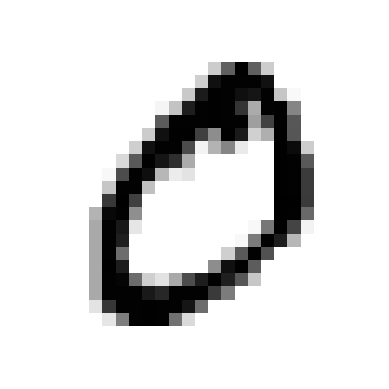

In [5]:
# Display the tensor image using matplotlib
def imshow(tensor_image):
  if tensor_image.shape[0] == 784:  # 28*28
    # if the image has been flattened, reshape it so that it can be drawn
    tensor_image = tensor_image.reshape(28,28)
  plt.imshow(tensor_image, cmap='gray')
  plt.axis('off')
  plt.show()

imshow(tensor_image)

In [6]:
# Our Multi-Layer Perceptron

class MNISTNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.Layer1 = nn.Linear(28*28, 100)
    self.Layer2 = nn.Linear(100, 150)
    self.Layer3 = nn.Linear(150, 10)

  def forward(self, x):
    x =  F.relu(self.Layer1(x))
    x =  F.relu(self.Layer2(x))
    x =  self.Layer3(x)
    return x


# 2. Preparing the data

We now need to load our dataset into objects that provide useful abstractions for PyTorch to work with data in a more organized and efficient way. These are Datasets and Dataloaders.


## 2.1 PyTorch Dataset

The Dataset class in PyTorch provides a consistent interface to access our data. It allows us to represent our data in a structured manner and define the methods to access it.

**Why is it needed?** Using Dataset makes our code cleaner and ensures we have a consistent way to handle various data sources. It also helps with data transformations and preprocessing, ensuring our data is always in the right format for our model.

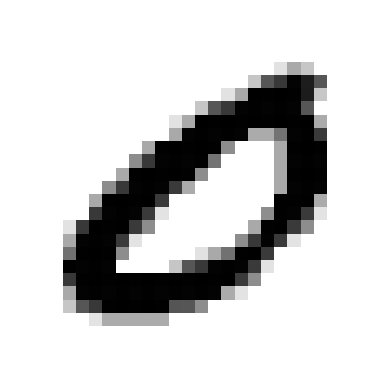

0


In [7]:
from torch.utils.data import DataLoader, Dataset

class MNISTDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for image_name in os.listdir(class_dir):
                self.samples.append((os.path.join(class_dir, image_name), class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        image = transform(image).squeeze(0).reshape(28*28)
        return image, label


train_dataset = MNISTDataset(root_dir="mnist/training/")

# To iterate through the dataset
for image, label in train_dataset:
  imshow(image)
  print(label)
  break



## 2.2 One-Hot Encoding of Labels

As we saw, one-hot encoding is a method used to represent categorical labels as binary vectors. For each unique value in the categorical data, one-hot encoding creates a new binary column, where the column corresponding to the categorical value is set to '1', and all other columns are set to '0'.

![picture](https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/3.4%20-%20Lab%20-%20Training%20MNIST%20Perceptron/one-hot-encoding.png)

The MNIST dataset consists of images representing handwritten digits, with labels ranging from 0 to 9 (a total of 10 classes). While these labels are numerical, they are categorical in nature. For instance, the digit '7' is not greater than the digit '1' in the context of classification. Using one-hot encoding allows our model to treat these labels as distinct categories without any inherent ordinal relationship.


Number of images 60000


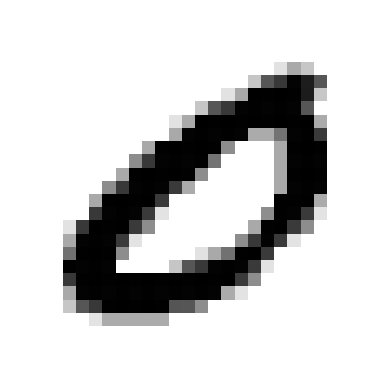

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [8]:
class MNISTDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Directory with all the images.
        """
        self.root_dir = root_dir
        self.samples = []
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for image_name in os.listdir(class_dir):
                self.samples.append((os.path.join(class_dir, image_name), class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        image = transform(image).squeeze(0).reshape(28*28)
        # Using PyTorch utility function one_hot to go from categorical
        # lables to one-hot encoded vectors
        y = F.one_hot(torch.tensor(label), len(self.classes)).float()
        return image, y

train_dataset = MNISTDataset(root_dir="mnist/training/")

print(f"Number of images {len(train_dataset)}")
# To iterate through the dataset
for image, label in train_dataset:
  imshow(image)
  print(label)
  break


## 2.3 Splitting into Training and Validation sets

This process involves dividing the original training dataset into two separate sets: a training set and a validation set.

* The **training** set is used to train the model.
* The **validation** set is used to evaluate the model's performance on unseen data during training without using the test set (that we will save for the end).

![picture](https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/3.4%20-%20Lab%20-%20Training%20MNIST%20Perceptron/dataset-split.png)


In [9]:
from torch.utils.data import random_split

# Define the split lengths
train_len = int(0.8 * len(train_dataset))
val_len = len(train_dataset) - train_len

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [train_len, val_len])

len(train_subset), len(val_subset)

(48000, 12000)

## 2.4 Preparing batches with DataLoaders

The DataLoader class in PyTorch provides a way to load data from a Dataset in batches, and it takes care of shuffling and sampling. It efficiently handles large datasets by loading them in chunks, ensuring that we don't run out of memory.

**Why is it needed?**

As we saw, training deep learning models on entire datasets can be computationally intensive and memory-consuming. DataLoader breaks down the dataset into manageable **batches**, allowing the model to update its weights iteratively on smaller portions of data. It also shuffles data to ensure that the training process is not biased by data order, facilitating better model generalization.


![picture](https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/3.4%20-%20Lab%20-%20Training%20MNIST%20Perceptron/mini-batch.gif)

In [10]:
BATCH_SIZE = 32
train_dl = DataLoader(train_subset, batch_size = BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_subset, batch_size = BATCH_SIZE, shuffle=False)

In [11]:
# Number of batches
len(train_dl), len(val_dl)

(1500, 375)

In [12]:
# Let's extract the first random batch
for x, y in train_dl:
  print(x.shape)
  print(y.shape)
  break

torch.Size([32, 784])
torch.Size([32, 10])


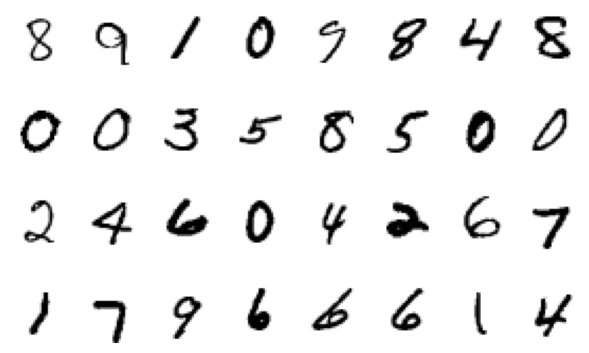

In [13]:
# Display the random batch nicely
def display_batch(x, labels = None):
    fig = plt.figure(figsize=(6,4))
    for i in range(32):
        ax = fig.add_subplot(4, 8, i+1)
        ax.imshow(x[i].reshape(28,28), cmap='gray')
         # Display label if provided
        if labels is not None:
            ax.set_title(str(labels[i]), fontsize=8)
        ax.axis('off')  # optionally hide axis for better visualization
    fig.tight_layout()
    plt.show()

display_batch(x)

# 3. Training Loop (mini-batch)

The train function represents the core of the training process for a deep learning model. Let's break down its key components:

![picture](https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/3.4%20-%20Lab%20-%20Training%20MNIST%20Perceptron/training-loop.png)

In [14]:
# Device-independent code
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

# Step 1: Instantiate the model with random parameters
model = MNISTNet()
model.to(DEVICE)
model

MNISTNet(
  (Layer1): Linear(in_features=784, out_features=100, bias=True)
  (Layer2): Linear(in_features=100, out_features=150, bias=True)
  (Layer3): Linear(in_features=150, out_features=10, bias=True)
)

In [15]:
# Training loop (minimal)
def train(model, dataloader, n_epochs, lr = 0.01):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)  # Stocastic Gradient Descent optimizer
  model.to(DEVICE)
  for epoch in range(n_epochs):
    model.train()                           # Training mode (computation graph/gradients)
    for i, (x, y) in enumerate(dataloader):
      x, y = x.to(DEVICE), y.to(DEVICE)
      y_hat = model(x)                      # Step 2: Forward pass
      optimizer.zero_grad()
      loss = F.cross_entropy(y_hat, y)      # Step 3: Calculate loss
      loss.backward()                       # Step 4: Backward pass
      optimizer.step()                      # Step 5: Backpropagation


In [16]:
# Training loop (collect loss data and print progress)
def train(model, dataloader, n_epochs, lr = 0.01):
  batch_num = len(dataloader)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  epoch_data = []
  loss_data = []

  model.to(DEVICE)
  for epoch in range(n_epochs):
    model.train()
    print(f"Epoch {epoch+1}/{n_epochs}")

    for i, (x, y) in enumerate(dataloader):
      x, y = x.to(DEVICE), y.to(DEVICE)
      y_hat = model(x)                      # Step 2: Forward pass
      optimizer.zero_grad()
      loss = F.cross_entropy(y_hat, y)      # Step 3: Calculate loss
      loss.backward()                       # Step 4: Backward pass
      optimizer.step()                      # Step 5: Backpropagation

      epoch_data.append(epoch+i/batch_num)
      loss_data.append(loss.item())

      if i % math.ceil(batch_num/10) == 0:
        print(f"Batch loss {i+1}/{batch_num}: {loss}")

  return np.array(epoch_data), np.array(loss_data)


In [17]:
# Training loop (with validation)
def train(model, train_dataloader, val_dataloader, n_epochs, lr = 0.01):
  batch_num = len(train_dataloader)

  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  epoch_data = []
  train_loss_data = []
  val_loss_data = []                        # Added to keep track of validation loss

  model.to(DEVICE)
  for epoch in range(n_epochs):
    # Training Phase
    model.train()
    print(f"Epoch {epoch+1}/{n_epochs}")
    total_train_loss = 0.0                  # Added to keep track of avg loss for validation per epoch
    for i, (x, y) in enumerate(train_dataloader):
      x, y = x.to(DEVICE), y.to(DEVICE)
      y_hat = model(x)                      # Step 2: Forward pass
      optimizer.zero_grad()
      loss = F.cross_entropy(y_hat, y)      # Step 3: Calculate loss
      loss.backward()                       # Step 4: Backward pass
      optimizer.step()                      # Step 5: Backpropagation

      total_train_loss += loss.item()       # Added to keep track of avg loss for validation per epoch
      epoch_data.append(epoch+i/batch_num)
      train_loss_data.append(loss.item())

      if i % math.ceil(batch_num/10) == 0:
        print(f"Batch loss {i+1}/{batch_num}: {loss}")

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation Phase
    model.eval()                          # Evauation mode (no computation graph/gradients)
    total_val_loss = 0.0
    with torch.inference_mode():
        for x, y in val_dataloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_loss_data.append(avg_val_loss)

    print(f"Average Training Loss: {avg_train_loss:.4f} - Average Validation Loss: {avg_val_loss:.4f}")

  return np.array(epoch_data), np.array(train_loss_data), np.array(val_loss_data)


In [18]:
# Run the training loop for 5 epochs
N_EPOCHS = 5
epoch_data, train_loss_data, val_loss_data = train(model, train_dl, val_dl, n_epochs = N_EPOCHS)

Epoch 1/5
Batch loss 1/1500: 2.307478904724121
Batch loss 151/1500: 2.192587375640869
Batch loss 301/1500: 1.808002233505249
Batch loss 451/1500: 1.5185308456420898
Batch loss 601/1500: 1.0412840843200684
Batch loss 751/1500: 0.858609676361084
Batch loss 901/1500: 0.9086148142814636
Batch loss 1051/1500: 0.5191254615783691
Batch loss 1201/1500: 0.479999303817749
Batch loss 1351/1500: 0.4025840759277344
Average Training Loss: 1.1355 - Average Validation Loss: 0.4824
Epoch 2/5
Batch loss 1/1500: 0.4147431552410126
Batch loss 151/1500: 0.44959551095962524
Batch loss 301/1500: 0.39470231533050537
Batch loss 451/1500: 0.32324498891830444
Batch loss 601/1500: 0.30503612756729126
Batch loss 751/1500: 0.3187791705131531
Batch loss 901/1500: 0.5789116621017456
Batch loss 1051/1500: 0.2578529417514801
Batch loss 1201/1500: 0.35530850291252136
Batch loss 1351/1500: 0.4107944965362549
Average Training Loss: 0.4412 - Average Validation Loss: 0.3805
Epoch 3/5
Batch loss 1/1500: 0.28723466396331787
B

## 3.1 Plot loss curve

When training a deep learning model, it's crucial to visualize the model's performance to understand its behavior and identify potential issues. One of the primary ways to achieve this is by plotting the loss curve.

**Loss curve**

A loss curve is a graphical representation that shows how the loss (or error) of a model changes over time (or iterations). It provides insights into the following:

* **Convergence**: If the loss is decreasing and eventually stabilizes, it suggests the model is learning and converging to a solution.

* **Overfitting**: If the training loss continues to decrease but a validation/test loss starts to increase, it's an indicator of overfitting. This means the model is performing well on the training data but not generalizing well to unseen data.

* **Need for Hyperparameter Tuning**: If the loss is fluctuating significantly or not decreasing, it may indicate the need for changes in learning rate, model architecture, or other hyperparameters.



### Loss Curve per Batch

This curve is plotted using the loss values from each batch during training. Given the stochastic nature of SGD and mini-batch training, this curve might be noisy, reflecting the variations in the loss for different batches. It provides a fine-grained view of the model's training behavior.

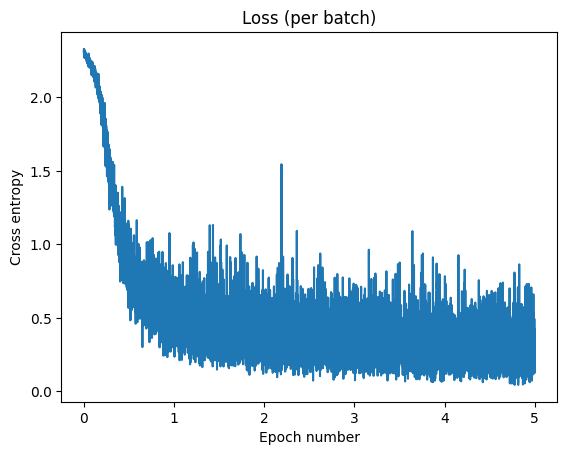

In [19]:
import numpy as np

def plot_loss_per_batch(epoch_data, loss_data):
  plt.plot(epoch_data, loss_data)
  plt.title('Loss (per batch)')
  plt.xlabel('Epoch number')
  plt.ylabel('Cross entropy')

plot_loss_per_batch(epoch_data, train_loss_data)

### Average Loss per Epoch

This curve is plotted by taking the average loss over all batches in an epoch. It gives a smoother representation of the model's performance, making it easier to identify general trends and patterns without the noise from individual batch variations.



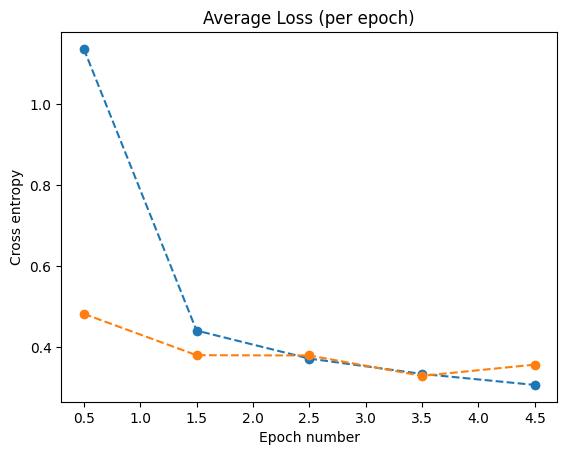

In [20]:
def plot_avg_loss_per_epoch(epoch_data, train_loss_data, val_loss_data, n_epochs):
  epoch_data_avgd = epoch_data.reshape(n_epochs,-1).mean(axis=1)
  losses_data_avgd = train_loss_data.reshape(n_epochs,-1).mean(axis=1)

  plt.plot(epoch_data_avgd, losses_data_avgd, 'o--')
  plt.plot(epoch_data_avgd, val_loss_data, 'o--')
  plt.title('Average Loss (per epoch)')
  plt.xlabel('Epoch number')
  plt.ylabel('Cross entropy')

plot_avg_loss_per_epoch(epoch_data, train_loss_data, val_loss_data, n_epochs = N_EPOCHS)

# Saving and using the model

To save your PyTorch model:

- Save only the model's parameters using the state_dict method. This captures the model's learned parameters without saving the entire model structure.

When you want to load the saved model:

- First, initialize the architecture of your model as you did during training.
- Load the saved parameters into this model structure using the load_state_dict method.

Remember, after loading, set your model to evaluation mode using the .eval() method before making predictions, especially in production.

In [21]:
# Save only the model's state_dict:
torch.save(model.state_dict(), 'model_state_dict.pth')

In [22]:
#Load only the model's state_dict:
model1 = MNISTNet()
model1.load_state_dict(torch.load('model_state_dict.pth'))
model1

<ipython-input-22-60c6d65b9477>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('model_state_dict.pth'))


MNISTNet(
  (Layer1): Linear(in_features=784, out_features=100, bias=True)
  (Layer2): Linear(in_features=100, out_features=150, bias=True)
  (Layer3): Linear(in_features=150, out_features=10, bias=True)
)

In [23]:
# Inference on unseen image
image_path = 'mnist/testing/0/10.png'
image = Image.open(image_path)
image

In [24]:
def recognize_digit(model, image):
  model.eval()
  x = transform(image).squeeze(0).reshape(28*28)
  with torch.inference_mode():
    label = model(x.unsqueeze(0))  # using unsqueeze to add a batch dimension

  return label.argmax(1).item()


In [25]:
recognize_digit(model1, image)

0

In [26]:
image_path = 'mnist/testing/7/1012.png'
image = Image.open(image_path)
recognize_digit(model1, image)

7

# Full-Batch and Incremental Updates

By changing the batch size, we can see how the other approaches to updaing weights work.


![picture](https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/3.4%20-%20Lab%20-%20Training%20MNIST%20Perceptron/full-batch-incremental.png)

## Incremental Updates

In [27]:
BATCH_SIZE = 1
train_incremental_dl = DataLoader(train_subset, batch_size = BATCH_SIZE, shuffle=True)

len(train_incremental_dl)

48000

In [28]:
model2 = MNISTNet().to(DEVICE)

epoch_data, train_loss_data, val_loss_data = train(model2, train_incremental_dl, val_dl, n_epochs = N_EPOCHS)

Epoch 1/5
Batch loss 1/48000: 2.4233999252319336
Batch loss 4801/48000: 0.019081950187683105
Batch loss 9601/48000: 0.12687020003795624
Batch loss 14401/48000: 0.9022299647331238
Batch loss 19201/48000: 2.34371280670166
Batch loss 24001/48000: 0.00045813556062057614
Batch loss 28801/48000: 0.848396360874176
Batch loss 33601/48000: 0.30394697189331055
Batch loss 38401/48000: 0.12344062328338623
Batch loss 43201/48000: 3.5523738915799186e-05
Average Training Loss: 0.6084 - Average Validation Loss: 0.4409
Epoch 2/5
Batch loss 1/48000: 1.6331539882230572e-05
Batch loss 4801/48000: 0.33588895201683044
Batch loss 9601/48000: 0.11826897412538528
Batch loss 14401/48000: 0.1866297721862793
Batch loss 19201/48000: 0.0024990777019411325
Batch loss 24001/48000: 0.0015573289711028337
Batch loss 28801/48000: 2.2047505378723145
Batch loss 33601/48000: 5.328513361746445e-05
Batch loss 38401/48000: 3.6954811548639555e-06
Batch loss 43201/48000: 0.0002791491860989481
Average Training Loss: 0.3848 - Aver

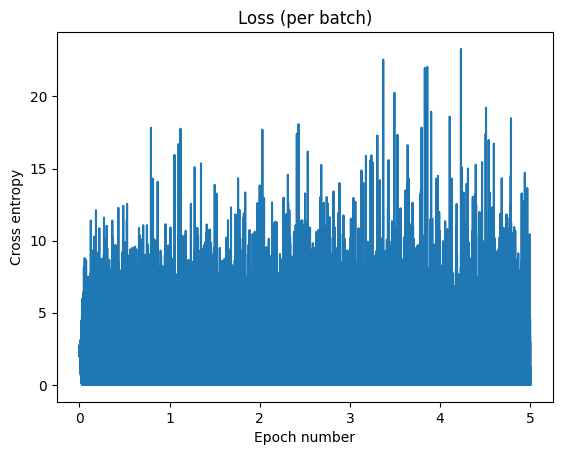

In [29]:
plot_loss_per_batch(epoch_data, train_loss_data)

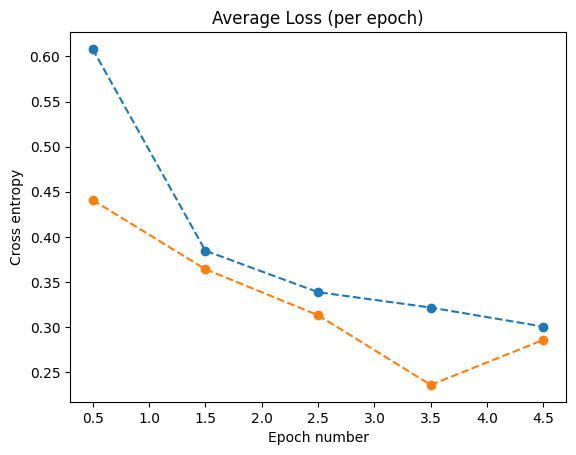

In [30]:
plot_avg_loss_per_epoch(epoch_data, train_loss_data, val_loss_data, n_epochs = N_EPOCHS)

# Evaluation

While loss is a vital tool during training, evaluating a model requires a holistic view, considering various metrics that capture the nuances of real-world performance.


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

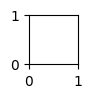

In [31]:
test_dl = DataLoader(MNISTDataset(root_dir="mnist/testing/"), batch_size = 32, shuffle=True)

i = 1
for x,y in test_dl:
  x = x.to(DEVICE)
  y = model(x)
  display_batch(x, labels = y.argmax(1))
  break



## Accuracy

Accuracy represents the overall effectiveness of our model. It tells us the percentage of correct predictions the model made. In other words, how often is the system right?

![picture](https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/3.5%20-%20Lab%20-%20Evaluation/accuracy.png)

In [32]:
def calculate_accuracy(model, dataloader):
    model.to(DEVICE)
    model.eval()    # Set the model to evaluation mode

    correct = 0
    total = 0

    # Disabling gradient computation
    with torch.inference_mode():
        for x, y in dataloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_hat = model(x)

            predicted_classes = y_hat.argmax(1)
            total += y.size(0)
            correct += (predicted_classes == y.argmax(1)).sum().item()

    accuracy = 100 * correct / total
    return round(accuracy,2)

In [33]:
calculate_accuracy(model, test_dl)

89.51

In [34]:
calculate_accuracy(model, train_dl)

89.32

In [35]:
calculate_accuracy(model2, test_dl)

92.33

## Confusion Matrix

A confusion matrix is a table used in classification to understand the performance of a machine learning model. Each row of the matrix represents the actual class, while each column represents the predicted class. The main diagonal represents correct predictions, while other entries outside this diagonal indicate errors. Key metrics such as accuracy, precision, and recall can be derived from the confusion matrix to provide insights into the classifier's performance.




In [36]:
import seaborn as sns

def confusion_matrix(model, dataloader):
  num_classes = 10
  confusion_matrix = torch.zeros(num_classes, num_classes)

  model.to(DEVICE)

  with torch.inference_mode():
    for x, y in dataloader:
      x,y = x.to(DEVICE), y.to(DEVICE)
      y_hat = model(x)
      _, preds = torch.max(y_hat, 1)  # get the predicted class
      _, true_classes = torch.max(y, 1)  # convert one-hot encoding to class labels
      for t, p in zip(true_classes.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

  return confusion_matrix

def plot_confusion_matrix(matrix):
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, cmap='Greens', fmt='g', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()





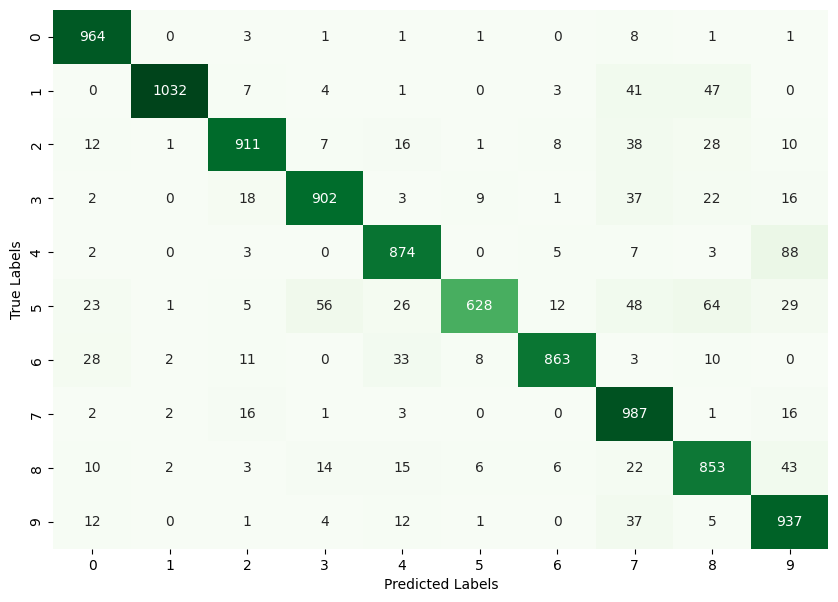

In [37]:
matrix = confusion_matrix(model, test_dl)
plot_confusion_matrix(matrix)

## Precision and Recall for Multi-class Classification

In binary classification, precision and recall are straightforward.

![picture](https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/3.5%20-%20Lab%20-%20Evaluation/Precision-Recall.png)

For multi-class classification, things are a bit more complex. You have to treat each class as if it's the positive class, and all other classes as the negative class. This is called the **one-vs-all** approach.

- **Precision for Class X**: Number of correct predictions of class X divided by the total number of times you predicted X.

- **Recall for Class X**: Number of correct predictions of class X divided by the total number of actual occurrences of X in the dataset.

We'll use the confusion matrix to compute precision and recall for each class in the MNIST dataset.






In [38]:
# Compute precision and recall using the formulas for each class as if it's
# the positive class and all other classes are the negative class (one-vs-all approach).
def precision_recall_from_confusion_matrix(confusion_mtx):
    precision = {}
    recall = {}

    for i in range(confusion_mtx.shape[0]):
        tp = confusion_mtx[i, i]
        fp = confusion_mtx[:, i].sum() - tp
        fn = confusion_mtx[i, :].sum() - tp

        precision[i] = tp / (tp + fp)
        recall[i] = tp / (tp + fn)

    return precision, recall

precision, recall = precision_recall_from_confusion_matrix(matrix)

for i in range(10):
    print(f"Class {i} - Precision: {precision[i]:.4f} - Recall: {recall[i]:.4f}")

Class 0 - Precision: 0.9137 - Recall: 0.9837
Class 1 - Precision: 0.9923 - Recall: 0.9093
Class 2 - Precision: 0.9315 - Recall: 0.8828
Class 3 - Precision: 0.9120 - Recall: 0.8931
Class 4 - Precision: 0.8882 - Recall: 0.8900
Class 5 - Precision: 0.9602 - Recall: 0.7040
Class 6 - Precision: 0.9610 - Recall: 0.9008
Class 7 - Precision: 0.8037 - Recall: 0.9601
Class 8 - Precision: 0.8250 - Recall: 0.8758
Class 9 - Precision: 0.8219 - Recall: 0.9286
